# Malaria Parametric Classification

The parametric classification is carried out on a repository of segmented cells from the thin blood smear slide images from the Malaria Screener research activity. The images come from samples Giemsa-stained thin blood smear slides from 150 P. falciparum-infected and 50 healthy patients were collected and photographed at Chittagong Medical College Hospital, Bangladesh. 

Classification is done by extracting a feature from the sample using clustering by k-mean to identify the proportion of infected and uninfected area. This classification is carried out according to the imposed cost restrictions.

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.cluster import KMeans
from multiprocessing import Pool
import cv2
import struct
import scipy
import scipy.misc
import scipy.cluster
import scipy.stats as st
import statsmodels as sm
from scipy.special import gamma as gammaf
from scipy.optimize import fmin
from scipy.stats import genextreme as gev
import numpy as np 
import pandas as pd
import os

## 1. Loading the data

Initially we proceed to load the data, to visualize the number of infected and uninfected samples.

In [2]:
root = "../input/cell_images/cell_images"
root_uninfected = root + '/Uninfected'
root_infected = root + '/Parasitized'
print(os.listdir(root))
files_uninfected = os.listdir(root_uninfected)
files_infected = os.listdir(root_infected)
print('{} uninfected files'.format(len(files_uninfected)))
print('{} infected files'.format(len(files_infected)))

['Parasitized', 'Uninfected']
13780 uninfected files
13780 infected files


Later we define a function that allows us to extract sub-samples, and then visualize them in a figure. At first glance the infected cells in the second column of the figure show drastic changes in color intensity by sectors (spots) in contrast to uninfected cells (first column). 

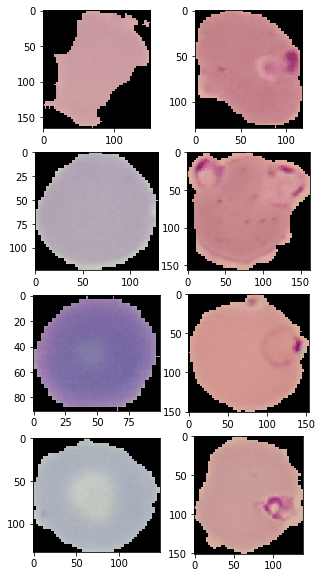

In [3]:
# Extraction function
def sample(y, k):
    if y == 0:
        return mpimg.imread(os.path.join(root_uninfected, files_uninfected[k]))
    elif y == 1:
        return mpimg.imread(os.path.join(root_infected, files_infected[k]))
    else:
        raise ValueError
        
# Figure of 8 sub-samples
f, ax = plt.subplots(4, 2, figsize=(5, 10))
for k in range(4):
    for y in range(2):
        ax[k][y].imshow(sample(y, k))

## 2. Feature extraction

For this case, clustering using k-mean is considered. Thus, for each image all possible clusters are selected and then the cluster is selected with less frequency. This chosen cluster, in the images with malaria, defines the infected area. Subsequently, the image is transformed into a black and white scale where the cluster is defined by white, in this sense, the infected image will have a much higher proportion of black color than the white color. Therefore, an infected image will have a proportion of black close to 100%, while the uninfected will have a proportion close to 0%. By default 7 clusters are selected, and therefore, a greater weight is assigned to the negative proportion.

Clustering is the task of grouping together a set of objects in a way that objects in the same cluster are more similar to each other than to objects in other clusters. Similarity is a metric that reflects the strength of relationship between two data objects [1]. K-means is a grouping technique based on centroid, where the latter is the arithmetic mean of all points belonging to the cluster. In this grouping, the clusters are represented by a central vector.

Thus, the algorithm considered to apply such technique corresponds to KMeans of the sklearn.cluster package. As a first step we proceed to define the clustering function by k-means. Once the clusters are defined within the image, they are transformed to a black and white scale, to then count the proportion of black and white pixels. In this sense, a proportion of black close to 100% indicates a high malaria infection.

In [4]:
# Definition feature extraction
def inf(im):
    
    # Clustering
    NUM_CLUSTERS = 7
    ar = np.asarray(im)
    shape = ar.shape
    ar = ar.reshape(scipy.product(shape[:2]), shape[2]).astype(float)
    codes, dist = scipy.cluster.vq.kmeans(ar, NUM_CLUSTERS)
    vecs, dist = scipy.cluster.vq.vq(ar, codes)         
    counts, bins = scipy.histogram(vecs, len(codes))    
    index_max = scipy.argmax(counts)                  
    peak = codes[index_max]
    colour = ''.join(chr(int(c)) for c in peak).encode()
    index_min = scipy.argmin(counts)                   
    peak2 = codes[index_min]
    colour2 = ''.join(chr(int(c)) for c in peak2).encode()
    thresholded=cv2.inRange(im,(0,0,0),(0,0,0))
    
    # Transform clustered image to black and white scale
    im=im+cv2.cvtColor(thresholded,cv2.COLOR_GRAY2BGR)
    th=cv2.inRange(im,(0,0,0),(peak2[0],peak2[1],peak2[2]))
    im=cv2.cvtColor(th,cv2.COLOR_GRAY2BGR)
    
    # Count the proportion of black and white pixels inside the image
    I, J, K = im.shape
    I, J, K
    bla = 0
    neg = 0
    for i in range(I):
        for j in range(J):
            if all(np.isclose(im[i, j], [0, 0, 0])):
                neg += 1
            else:
                bla += 1
    tot = neg+bla
    Pneg = neg/tot
    Pbla = bla/tot
    return Pneg 

## 3. Validation analysis

Next, we proceed to select a set of 1000 samples of infected and uninfected cells for a 'validation' of the effectiveness of our feature.

In [5]:
N_samples = 1000
samples_uninfected = [sample(0, i) for i in range(N_samples)]
samples_infected = [sample(1, i) for i in range(N_samples)]

Feature is extracted for selected samples

In [6]:
pool = Pool(8)
X_uninfected = pool.map(inf, samples_uninfected)
X_infected = pool.map(inf, samples_infected)

We proceed to take the histograms of the feature extracted on the 1000 images.

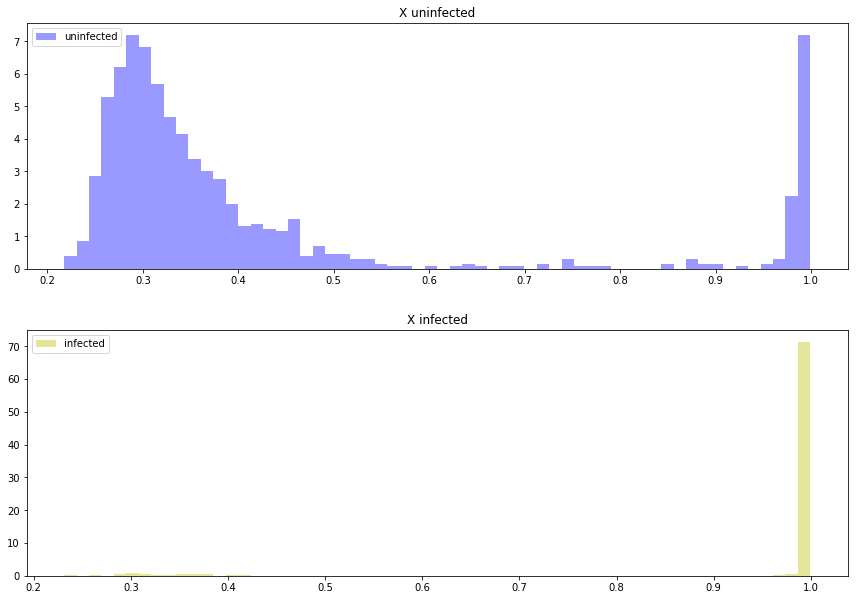

In [7]:
plt.subplot(2,1,1)
plt.hist(X_uninfected, bins=60, color='b', density=True, alpha=0.4, label='uninfected')
plt.legend()
plt.title('X uninfected')

plt.subplot(2,1,2)
plt.hist(X_infected, bins=60, color='y', density=True, alpha=0.4, label='infected')
plt.legend()
plt.title('X infected')

plt.subplots_adjust(top=2, bottom=0.08, left=0.10, right=2, hspace=0.25, wspace=0.35)
plt.show()

Both histograms show ouliers and therefore we extract them, to observe more clearly the possible distributions. In this sense, for the infected case, those whose proportion of black is above 90% are selected, while for the non-infected case, those that are below 70% are selected. Afterwards, the results are displayed.

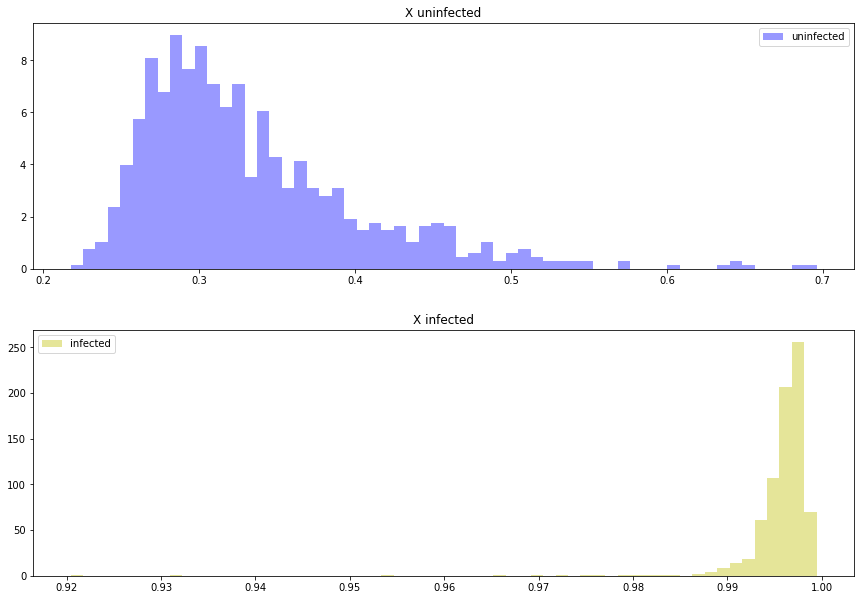

In [8]:
b = np.asarray(X_uninfected)<=0.7
X_uninfected = np.extract(b, np.asarray(X_uninfected))
plt.subplot(2,1,1)
plt.hist(X_uninfected, bins=60, color='b', density=True, alpha=0.4, label='uninfected')
plt.legend()
plt.title('X uninfected')

c = np.asarray(X_infected)>0.9
X_infected = np.extract(c, np.asarray(X_infected))
plt.subplot(2,1,2)
plt.hist(X_infected, bins=60, color='y', density=True, alpha=0.4, label='infected')
plt.legend()
plt.title('X infected')

plt.subplots_adjust(top=2, bottom=0.08, left=0.10, right=2, hspace=0.25, wspace=0.35)
plt.show()


### 3.1. Modeling the extracted features

The results of the histograms indicate that the features extracted from the uninfected cells can be modeled from a lognormal distribution, while the extracted features of the infected cells can be modeled from a weibull distribution. Such that,

* Lognormal distribution:

$f_X(x) =\frac{1}{\sigma x \sqrt{2\pi}}\exp{\left(-\frac{(\log (x)-\mu)^{2}}{2\sigma^{2}}\right)}$

* Weibull distribution

$f_X(x; \lambda, k) = \frac{k}{\lambda}\Bigl(\frac{x}{k}\Bigr)^{k-1} \exp\bigl(-(x/\lambda)^k\bigr)$

#### For uninfected features extracted

mu: -1.118, sigma: 0.195


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


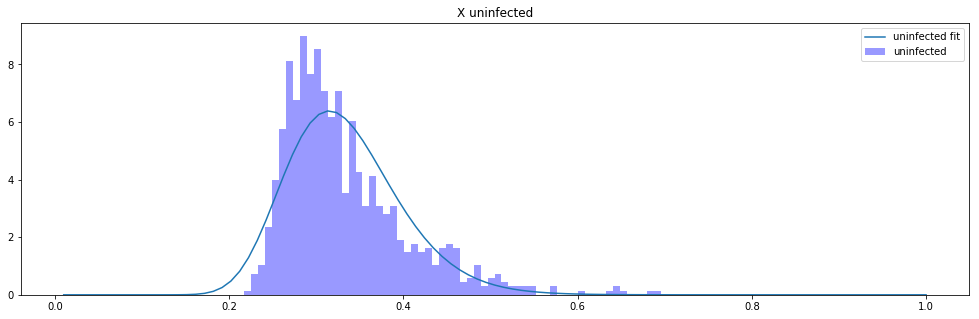

In [9]:
# Definition of the probability function
def lognormal(mu, sigma):
    def fun(x):
        return np.exp(- (np.log(x) - mu) ** 2 /(2 * sigma ** 2)) / (x * sigma * (2 * np.pi) ** 0.5) 
    return fun

# Calculation of the probability function and histogram
log_Xuninfected = np.log(X_uninfected)
mu0 = np.mean(log_Xuninfected)
sigma0 = np.std(log_Xuninfected)
print('mu: {:.3f}, sigma: {:.3f}'.format(mu0, sigma0))

X0 = lognormal(mu0, sigma0)
plt.figure(figsize=(17,5))
dom = np.linspace(0, 1, 100)
plt.hist(X_uninfected, bins=60, color='b', density=True, alpha=0.4, label='uninfected')
plt.plot(dom, list(map(X0, dom)), label='uninfected fit')
plt.legend()
plt.title('X uninfected')
plt.show()

#### For infected features extracted

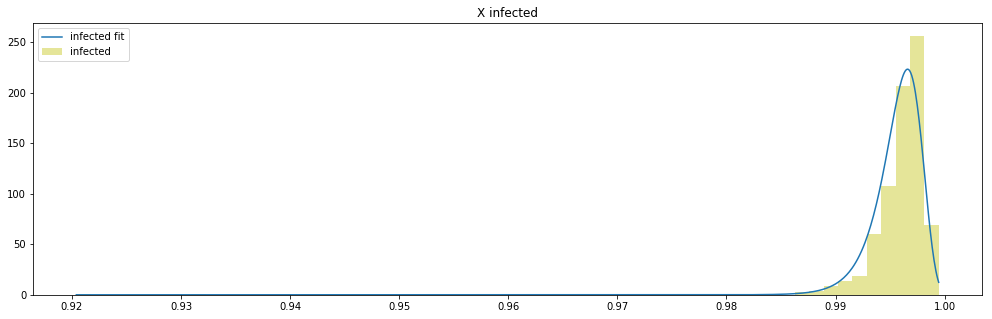

In [10]:
# Definition of the probability function
data=X_infected
(w1, w2, w3, w4)=st.exponweib.fit(data,floc=0, f0=np.median(data))
def weib(n,a):
    def fun(x):
        return (a / n) * (x / n)**(a - 1) * np.exp(-(x / n)**a)
    return fun

# Calculation of the probability function and histogram
X1 = weib(w1, w2)
plt.figure(figsize=(17,5))
dom = np.linspace(min(data),max(data),len(data))
plt.hist(X_infected, bins=60, color='y', density=True, alpha=0.4, label='infected')
plt.plot(dom, list(map(X1, dom)), label='infected fit')
plt.legend()
plt.title('X infected')
plt.show()

## 4. Defining the test sample

For this case we chose another 1000 infected and uninfected samples on which the feature extraction will be done.

In [11]:
# Choice of random samples
N_samples_test = 1000
samples_uninfected_test = [sample(0, 1000 + i) for i in range(N_samples_test)]
samples_infected_test = [sample(1, 1000 + i) for i in range(N_samples_test)]
pool = Pool(4)

# Feature extraction 
X_uninfected_test = pool.map(inf, samples_uninfected_test)
X_infected_test = pool.map(inf, samples_infected_test)

## 5. Classifier and ROC curve of the model

Based on the parametric modeling of the extracted features for the infected and uninfected cells, we proceed to construct the parametric classifier. This classifier, depends on a relative cost of a false negative vs a false positive ($r$), the proportion of positives in the population ($p_1$), and the density function estimated from the training data for the infected ($X_{1}$) and uninfected ($X_{0}$) cells. Therefore the classifier throws 1 if the cell is infected and 0 otherwise.

In [12]:
# Classifier definition
def clasificador(r, p1, X0, X1):
    def phi(x):
        q0 = r * p1 * X0(x)
        q1 = (1 - p1) * X1(x)
        if q0 < q1:
            return 0
        else:
            return 1
    return phi

Let's suppose that the incidence of malaria is 0.5 per 10000 inhabitants and incremental costs.

In [13]:
costos = [1e-1, 1, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 
          1e8, 1e9, 1e10, 1e11, 1e12, 1e13, 1e14, 1e15, 1e16, 1e17, 1e18, 1e19, 1e20, 
          1e21, 1e22, 1e23, 1e24, 1e25, 1e26, 1e27, 1e28, 1e29, 1e30, 1e31, 1e32, 1e33, 1e34, 1e35,
         1e36, 1e37, 1e38, 1e39, 1e40, 1e41, 1e42, 1e43, 1e44, 1e45, 1e46, 1e47, 1e48, 1e49, 1e50,
         1e51, 1e52, 1e53, 1e54, 1e55, 1e56, 1e57, 1e58, 1e59, 1e60,
         1e61, 1e62, 1e63, 1e64, 1e65, 1e66, 1e67, 1e68, 1e69, 1e70,
         1e71, 1e72, 1e73, 1e74, 1e75, 1e76, 1e77, 1e78, 1e79, 1e80,
         1e81, 1e82, 1e83, 1e84, 1e85, 1e86, 1e87, 1e88, 1e89, 1e90] 
p1 = 0.5 / 10000

In turn the functions that define the true positive rate and false positive rate are given by,

In [14]:
# False positive rate
def fp_fn(phi, p1, X_uninfected, X_infected):
    fpr = sum(map(phi, X_uninfected)) / len(X_uninfected)
    fp = fpr * (1 - p1)
    fnr = 1.0 - sum(map(phi, X_infected)) / len(X_infected)
    fn = fnr * p1
    return fp, fn

# True positive rate
def fpr_tpr(phi, X_uninfected, X_infected):
    fpr = sum(map(phi, X_uninfected)) / len(X_uninfected)
    tpr = sum(map(phi, X_infected)) / len(X_infected)
    return fpr, tpr

We proceed to calculate the ROC curve,

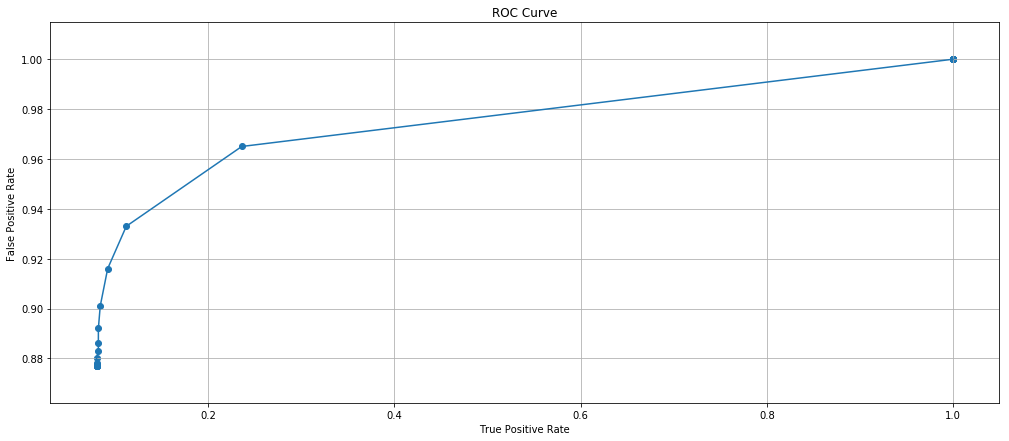

In [15]:
fn1s = []
fp1s = []
fpr1s = []
tpr1s = []
for r in costos:
    phi1 = clasificador(r, p1, X0, X1)
    fp1, fn1 = fp_fn(phi1, p1, X_uninfected_test, X_infected_test)
    fpr1, tpr1 = fpr_tpr(phi1, X_uninfected_test, X_infected_test)
    fn1s.append(fn1)
    fp1s.append(fp1)
    fpr1s.append(fpr1)
    tpr1s.append(tpr1)
    
plt.figure(figsize=(17,7))
plt.scatter(tpr1s, fpr1s)
plt.plot(tpr1s, fpr1s)
plt.xlabel('True Positive Rate')
plt.ylabel('False Positive Rate')
plt.title('ROC Curve')
plt.grid()
plt.show()


## 6. Conclusions

The parametric classification performed shows good results to identify from an image if a cell is infected with malaria or not. This classification was done by extracting only one feature on the sample. This method of classification turns out to be intuitive and interpretative, nevertheless, it presents numerous restrictions on the distributions assigned to the extracted features. Thus, for our case we assumed a lognormal and Weibull distribution over these features, where other distributions could work better. Additionally, we only extracted one feature, however, the modeling with more features would have provided better results. Regarding the extraction of features (k-mean), the method is successful despite its high computation time on large samples.

## References

[1] https://www.datacamp.com/community/tutorials/k-means-clustering-python